## Predict Risk of Stroke

In this section, prediction models including LogisticRegression and Support Vector Machine classifier are implemented to predict the diagnosis and the parameters for each model are optimized in order to obtain the good prediction performance. Specifically, the following steps are followed: 1) split the data into train data (for model selection) and test data (for model validation), 2) use natural language processing (apply stemming to text, compute occurance of words or term frequency–inverse document frequency to transform text notes, 3) perform lasso feature selection using linear support vector classifier, 4) implement and optimize two popular text classifier: the LogisticRegression and Support Vector Machine classifiers, 5) compare the performance of the optimized classifiers that are trained with occurance of words or term frequency–inverse document frequency.

### 1. Split train and test data
To test a model, the data are first separated into train (80%) and test (20%) data. The train data are used for training and cross-validation for each model. The test data are used to evaluate the final performance of each model.

In [1]:
# import library
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
import re
# set matplotlib style
%matplotlib inline
matplotlib.style.use('ggplot')
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

# read data from csv file
train_val_data = pd.read_csv('stroke_his_info.csv')

# get the midical, social and family history information
X = train_val_data['HISTORY INFO'].values
# get a list of labels (stroke or non-stroke)
labels = train_val_data['STROKE_LABEL'].values
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20,\
                                                    random_state = 42)
# examine the data shape in train and test data
print 'Train data: ', X_train.shape
print 'Test data: ', X_test.shape

Train data:  (3020,)
Test data:  (755,)


### 2. Natural language processing text notes
Because the data are texts, they have to be transformed before applying for a model. To do that, the history notes are tokenizer with stemming and converted into occurance of words with sklearn CountVectorizer or term frequency–inverse document frequency with TfidfVectorizer.

#### 2.1 Feature engineering

In [2]:
# import snow ball stemmmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def tokenizer(text):
    '''
    this function define a stemming to tokenizer words in the text
    '''
    stemmed = []
    # remove special characters and blank space
    text = re.sub('[^a-zA-Z0-9]+', ' ', text)
    text = re.sub('[ ]+', ' ', text)
    text.strip()
    # stemmized each word and return a list of the stemmized words
    words = text.split()
    for item in words:
        stemmed.append(stemmer.stem(item))   
    return stemmed

In [3]:
# converted notes into occurance of words with sklearn CountVectorizer
count_vec = CountVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
X_transform_count = count_vec.fit_transform(X_train)
print ('The number of features with count vectorizer transformation: %d'%X_transform_count.shape[1])
# converted notes into term frequency–inverse document frequency with TfidfVectorizer
tfidf_vec = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english', tokenizer = tokenizer)
X_transform_tfidf = tfidf_vec.fit_transform(X_train)
print ('The number of features with tfidf vectorizer transformation: %d'%X_transform_tfidf.shape[1])

X_test_count = count_vec.transform(X_test)
X_test_tfidf = tfidf_vec.transform(X_test)
print X_test_count.shape, X_test_tfidf.shape

The number of features with count vectorizer transformation: 67223
The number of features with tfidf vectorizer transformation: 67223
(755, 67223) (755, 67223)


The transformation yields 67223 features. Next, the labels need to be transformed as numeric values.

#### 2.2 Transform the labels

In [4]:
# transform labels
# define a dict to with key as a label and value as a numeric value
labels_dict = {'Stroke':1, 'Non-Stroke':0}
y_train_transform = [labels_dict[key] for key in y_train]
# examine the number of labels
print 'There are %d labels'%(len(y_train_transform))

There are 3020 labels


### 3. Feature selection with linear support vector machine and lasso 

#### 3.1 Define a funtion to select features

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

def feature_selection(clf, X, y, vec, title, xlabel, is_test = False):
    '''
    this function is used to train a model for feature selection
    '''
    # fit a classifier for feature selection model
    clf.fit(X, y)
    # apply the classifier to the model for feature selection
    model = SelectFromModel(clf, prefit=False)
    # get the selected new features
    X_new = model.fit_transform(X,y)
    # the following code is used to plot a graph for train data to visulize the 
    # selected features when the value of is_test is False. 
    if not is_test:
        # define the figure
        plt.Figure(figsize = (10, 16))
        # get the coefficient (or weight) for each feature
        coef = clf.coef_[0]
        # sort the index of coef according to the coef value
        indices = np.argsort(coef)[::-1]
        # get the index of coef which has a positive coef
        indices = [i for i in indices if coef[i] != 0]
        print 'There are %d features selected with %s' %(len(indices), xlabel)
        # get the feature_names
        feature_names = vec.get_feature_names()
        # get the interesting features that are relevant to stroke and their coef
        top_10_positive_coef = [coef[i] for i in indices[:14]]
        top_10_positive_coef += [coef[indices[28]]]
        top_10_positive_terms = [feature_names[i] for i in indices[:14]]
        top_10_positive_terms += [feature_names[indices[28]]]
        # use the pandas datafram to plot a graph for selected features
        df = pd.DataFrame({'Stroke relevant': top_10_positive_coef})
        df.index = top_10_positive_terms
        df.plot(kind = 'barh', color = 'darkblue')
        plt.gca().invert_yaxis()
        plt.legend().set_visible(False)
        plt.title(title, y = 1.1)
        plt.xlabel(xlabel)
        
    # return the selected features and the model used for selection    
    return X_new, model

#### 3.2 Define a function to search best classifier for feature selection model

In [6]:
from sklearn.model_selection import GridSearchCV
def search_best_params(X, y, clf, params):
    '''
    this method searchs the best parameters for a classifier
    '''
    model = GridSearchCV(clf, params, cv = 5, n_jobs =1, scoring = 'recall_macro')
    model.fit(X, y)
    best_parameter = model.best_params_
    return best_parameter

#### 3.3 Get best classifier for feature selection model and apply it for feature selection

In [7]:
# define the default models
lsvc_count = LinearSVC(penalty='l1', dual = False, random_state = 42)
lsvc_tfidf = LinearSVC(penalty='l1', dual = False, random_state = 42)
# define the search parameters
svc_parameters = {'C' : [0.1, 0.2, 0.25, 0.5, 10]} 
# search best parameters
best_params_count_select = search_best_params(X_transform_tfidf, y_train_transform, 
                                              lsvc_count, svc_parameters)
best_params_tfidf_select = search_best_params(X_transform_tfidf, y_train_transform, 
                                              lsvc_tfidf, svc_parameters)
print 'Best parameter for feature selection (word ocurance): ', best_params_count_select
print 'Best parameter for feature selection (tfidf): ', best_params_tfidf_select

Best parameter for feature selection (word ocurance):  {'C': 0.5}
Best parameter for feature selection (tfidf):  {'C': 0.5}


There are 253 features selected with Tfidf
There are 1600 features selected with Word occurance


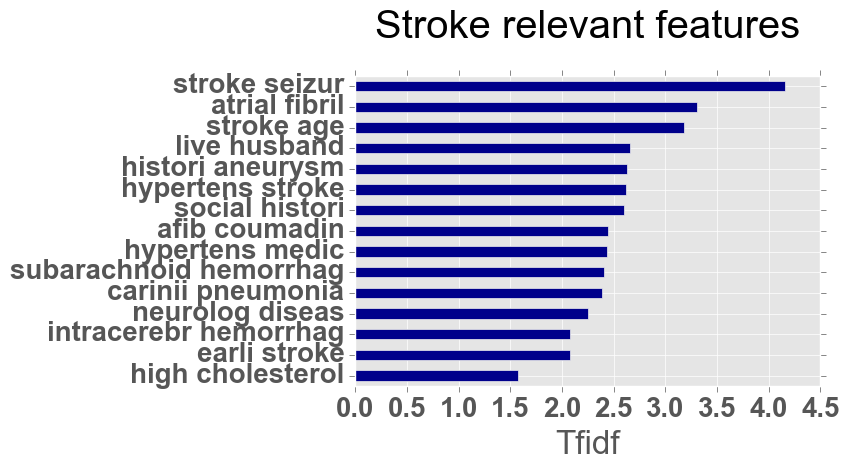

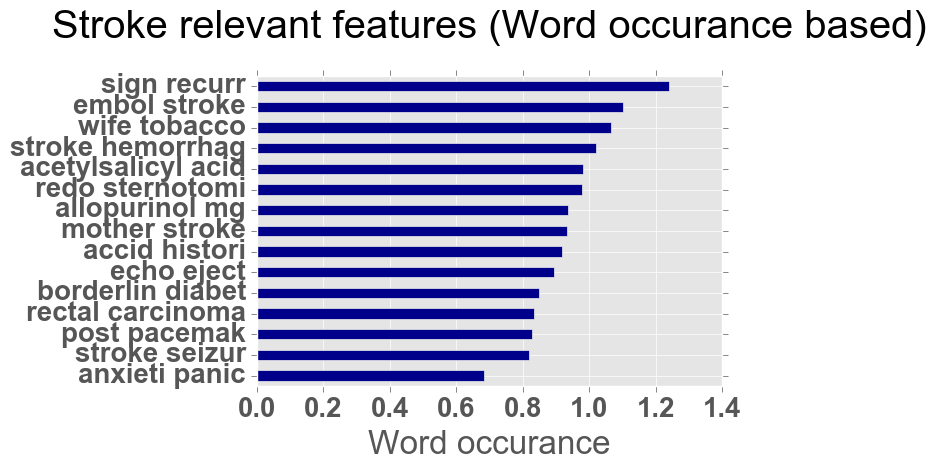

In [8]:
# define the linear svc with best parameters
lsvc_count_select = LinearSVC(penalty='l1', dual = False, random_state = 42, 
                              **best_params_count_select)
lsvc_tfidf_select = LinearSVC(penalty='l1', dual = False, random_state = 42, 
                              **best_params_tfidf_select)
# visulize the interesting features that are associated with stroke
title_tfidf = 'Stroke relevant features'
xlabel= 'Tfidf'
title_count = 'Stroke relevant features (Word occurance based)'
X_train_tfidf_selected, model_tfidf = feature_selection(lsvc_tfidf_select, X_transform_tfidf, 
                                            y_train_transform, tfidf_vec, title_tfidf, xlabel)
xlabel = 'Word occurance'
X_train_count_selected, model_count = feature_selection(lsvc_count_select, X_transform_count, 
                                            y_train_transform, count_vec, title_count, xlabel)

Both word occurance and tfidf captures some well known risk factors for stroke. The tfidf could identify the atrial fibril, which is a leading risk factor for stroke. The tfidf also recognized the the 'live husband' as an important feature relevant to stroke. The 'live husband' usually implies this patient is a female. This is consistent with the finding that females usually have high risk of stroke as compared to males at certain ages.  

### 4. LogisticRegression for text classification
With selected features, I trained first trained a LogisticRegression model.

#### 4.1 Define a function to plot learning curves

In [9]:
def plot_learning_curve(title, labels, colors, train_sizes_list, 
                        train_scores_list, test_scores_list, is_two_plots = False):
    '''
    this method plots training and cross-validation learning curves
    '''
    # define a figure layout and labels
    plt.figure(figsize = (10,8))
    plt.title(title)
    plt.xlabel('Training sample size')
    plt.ylabel('Recall Score')
    plt.grid()  
    plt.ylim([0.5, 1.0])
    # use length = 2 to plot 4 lines
    length = 2
    # used length = 1 to plot 2 lines
    if is_two_plots:
        length = 1
    for i in range(length):      
        line_label = labels[i]
        line_color = colors[i]
        train_sizes, train_scores, test_scores = train_sizes_list[i], \
                                                 train_scores_list[i], test_scores_list[i]
        # compute the mean score and standard deviation
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        # plot train curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color=line_color[0])
        plt.plot(train_sizes, train_scores_mean, 'o-', color=line_color[0],
                 label=line_label[0], linewidth = 5)
        # plot cross-validation curve
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=line_color[1])
        plt.plot(train_sizes, test_scores_mean, 'o-', color=line_color[1],
                 label=line_label[1], linewidth = 5)
        plt.legend(bbox_to_anchor=(0., 1.1, 1., .105),loc=3, mode='expand',
                   borderaxespad=0.)
    return plt

#### 4.2 Plot learning curves for LogisticRegression with default parameters

<module 'matplotlib.pyplot' from '/Volumes/Work/DataScience/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>


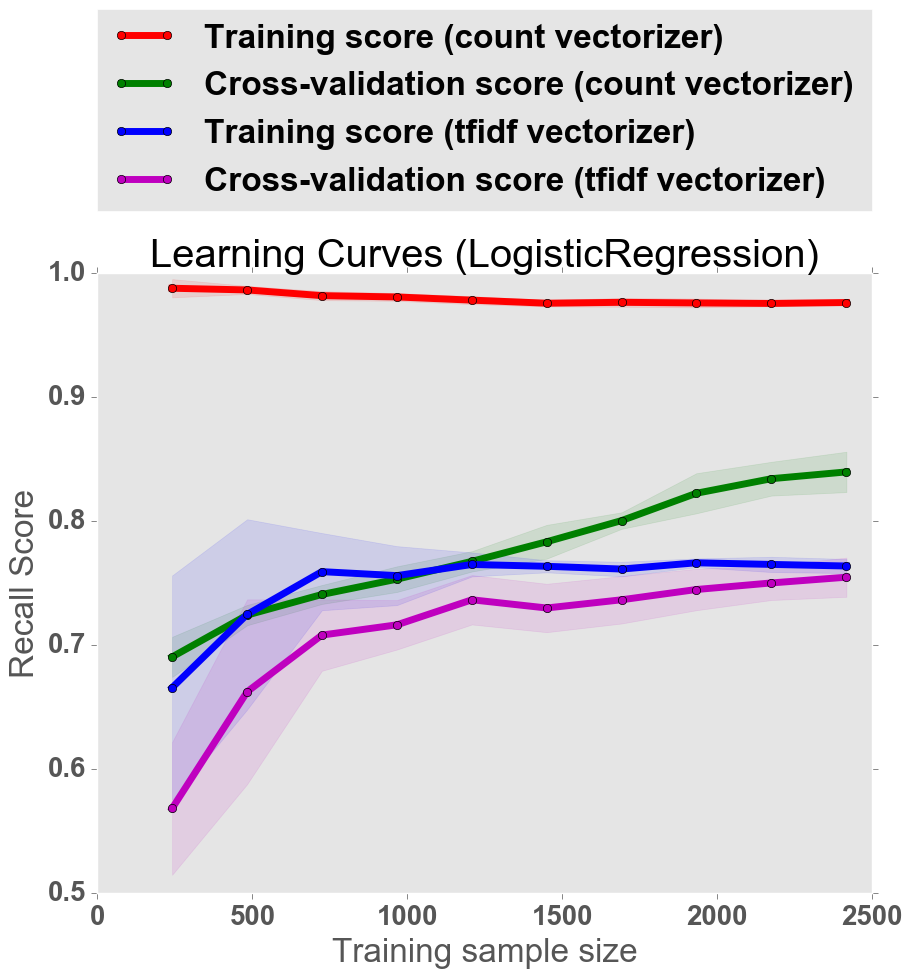

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit 
from sklearn.model_selection import learning_curve

train_sizes_list = []
train_scores_list = []
test_scores_list = []

# set up a LogisticRegression classifier
lr_clf_count = LogisticRegression(random_state=42)
lr_clf_tfidf = LogisticRegression(random_state=42)
title = 'Learning Curves (LogisticRegression)'
# set colors: r -red, g- green, b - blue, m - magenta
colors = [('r', 'g'), ('b', 'm')] 
labels1 = [('Training score (count vectorizer)', 
           'Cross-validation score (count vectorizer)'), ('Training score (tfidf vectorizer)', 
           'Cross-validation score (tfidf vectorizer)')]
        
# Cross validation with 20% data randomly selected as a validation set each time.
cv = ShuffleSplit(n_splits=5,test_size=0.2, random_state=42)
train_sizes=np.linspace(.1, 1.0, 10)

# get data trained with LogisticRegression based on CountVectorizer transformation
lr_train_sizes_count, lr_train_scores_count, lr_test_scores_count = learning_curve(
                lr_clf_count, X_train_count_selected, y_train_transform, 
                cv=cv, train_sizes=train_sizes, scoring = 'recall_macro')
train_sizes_list.append(lr_train_sizes_count)
train_scores_list.append(lr_train_scores_count)
test_scores_list.append(lr_test_scores_count)

# get data trained with LogisticRegression based on TfidfVectorizer transformation
lr_train_sizes_tfidf, lr_train_scores_tfidf, lr_test_scores_tfidf = learning_curve(
                lr_clf_tfidf, X_train_tfidf_selected, y_train_transform, 
                cv=cv, train_sizes=train_sizes)
train_sizes_list.append(lr_train_sizes_tfidf)
train_scores_list.append(lr_train_scores_tfidf)
test_scores_list.append(lr_test_scores_tfidf)

# generated learning curves to measure the performance of LogisticRegression with CountVectorizer 
# or TfidfVectorizer transformated data
print plot_learning_curve(title, labels1, colors, train_sizes_list, train_scores_list, 
                          test_scores_list)

Overall, the performance of LogisticRegression trained with TfidfVectorizer transformated data is highly biased and LogisticRegression trained with CountVectorizer transformated data are overfitted with the default parameters.

#### 4.3 Parameters optimization for LogisticRegression

In [11]:
# setup LogisticRegression classifiers
lr_clf_count = LogisticRegression(random_state=42)
lr_clf_tfidf = LogisticRegression(random_state=42)
# setup parameters for searching: tol - Tolerance for stopping criteria; C - Inverse of 
# regularization strength; must be a positive float. Like in support vector machines, 
# smaller values specify stronger regularization; penalty - Used to specify the norm used 
# in the penalization.
lr_parameters = {'tol' : np.logspace(-8, -3, 5),
                     'C' : np.logspace(-3, 3, 6),
                    'penalty': ['l1', 'l2']} 
# search best parameters
lr_best_params_count = search_best_params(X_train_count_selected, y_train_transform,lr_clf_count,
                                      lr_parameters)
lr_best_params_tfidf = search_best_params(X_train_tfidf_selected, y_train_transform, lr_clf_tfidf,
                                      lr_parameters)
print 'Best parameters for count vectorizer (Logistic Regression): ', lr_best_params_count
print 'Best parameters for tfidf vectorizer (Logistic Regression): ', lr_best_params_tfidf

Best parameters for count vectorizer (Logistic Regression):  {'penalty': 'l2', 'C': 63.0957344480193, 'tol': 0.001}
Best parameters for tfidf vectorizer (Logistic Regression):  {'penalty': 'l2', 'C': 1000.0, 'tol': 1e-08}


#### 4.4 Plot learning curves for LogisticRegression with optimized parameters

<module 'matplotlib.pyplot' from '/Volumes/Work/DataScience/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>


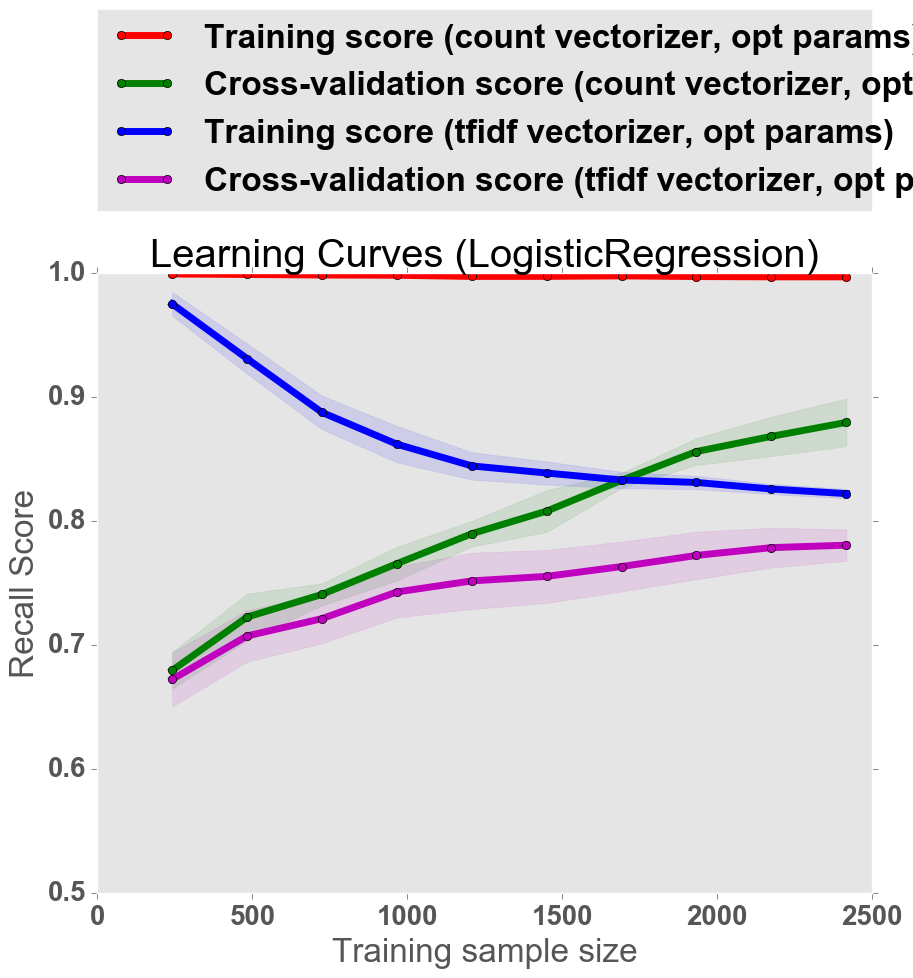

In [12]:
train_sizes_list = []
train_scores_list = []
test_scores_list = []
# define the LogisticRegression with best parameters
lr_clf_count_best = LogisticRegression(random_state=42,**lr_best_params_count)
lr_clf_tfidf_best = LogisticRegression(random_state=42,**lr_best_params_tfidf)
# set labels for graph
labels2 = [('Training score (count vectorizer, opt params)', 
           'Cross-validation score (count vectorizer, opt params)'), 
          ('Training score (tfidf vectorizer, opt params)', 
           'Cross-validation score (tfidf vectorizer, opt params)')]

# get data trained with LogisticRegression based on CountVectorizer transformation and optimized parameters
lr_train_sizes_count_best, lr_train_scores_count_best, lr_test_scores_count_best = learning_curve(
                lr_clf_count_best, X_train_count_selected, y_train_transform, 
                cv=cv, train_sizes=train_sizes)
train_sizes_list.append(lr_train_sizes_count_best)
train_scores_list.append(lr_train_scores_count_best)
test_scores_list.append(lr_test_scores_count_best)

# get data trained with LogisticRegression based on TfidfVectorizer transformation and optimized parameters
lr_train_sizes_tfidf_best, lr_train_scores_tfidf_best, lr_test_scores_tfidf_best = learning_curve(
                lr_clf_tfidf_best, X_train_tfidf_selected, y_train_transform,
                cv=cv, train_sizes=train_sizes)
train_sizes_list.append(lr_train_sizes_tfidf_best)
train_scores_list.append(lr_train_scores_tfidf_best)
test_scores_list.append(lr_test_scores_tfidf_best)

# generated learning curves to measure the performance of LogisticRegression with CountVectorizer 
# or TfidfVectorizer transformated data and optimizated parameters
print plot_learning_curve(title, labels2, colors, train_sizes_list, train_scores_list, 
                          test_scores_list)

<module 'matplotlib.pyplot' from '/Volumes/Work/DataScience/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>
<module 'matplotlib.pyplot' from '/Volumes/Work/DataScience/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>


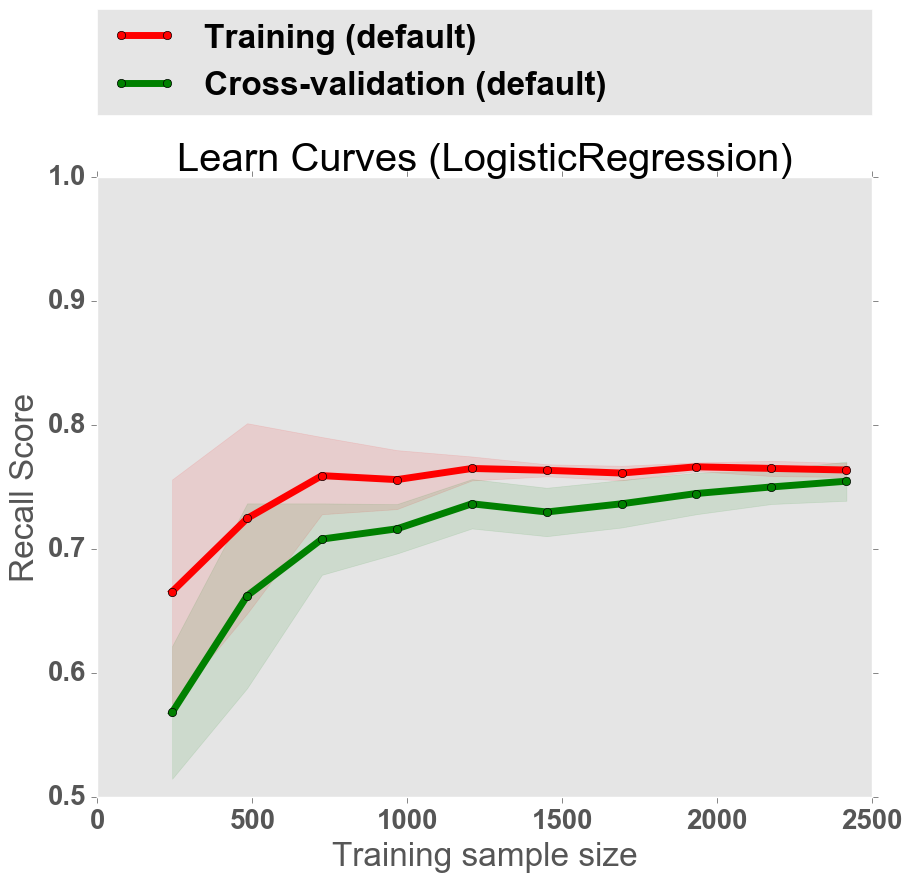

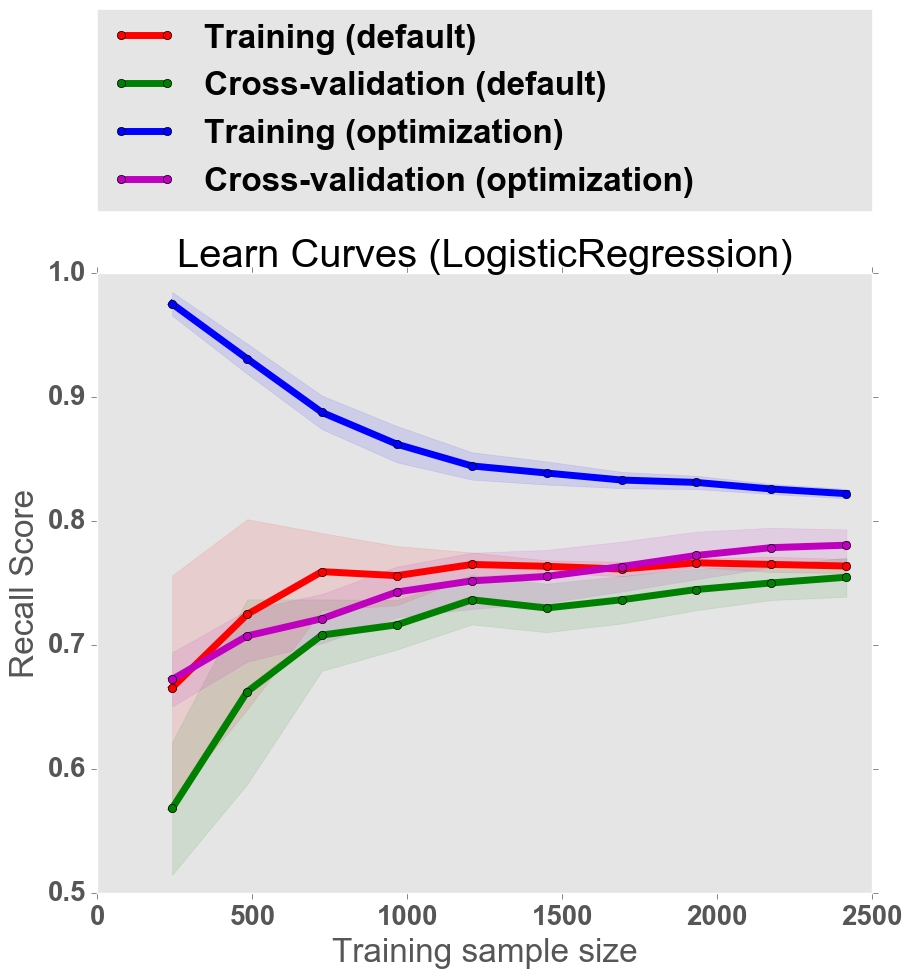

In [13]:
train_sizes_list = []
train_scores_list = []
test_scores_list = []

title = 'Learn Curves (LogisticRegression)'
labels3 = [('Training (default)', 
           'Cross-validation (default)')]
labels4 = labels3 + [('Training (optimization)', 
           'Cross-validation (optimization)')]

# Learning curves with tfidf with default parameters
train_sizes_list.append(lr_train_sizes_tfidf)
train_scores_list.append(lr_train_scores_tfidf)
test_scores_list.append(lr_test_scores_tfidf)
print plot_learning_curve(title, labels3, [colors[0]], train_sizes_list, train_scores_list, 
                          test_scores_list, is_two_plots = True)
# Learning curves with tfidf with default or optimizated parameters
train_sizes_list.append(lr_train_sizes_tfidf_best)
train_scores_list.append(lr_train_scores_tfidf_best)
test_scores_list.append(lr_test_scores_tfidf_best)
print plot_learning_curve(title, labels4, colors, train_sizes_list, train_scores_list, 
                          test_scores_list)

With the optimized parameters, there are improvements of performance of prediction for the LogisticRegression classifier trained with CountVectorizer transformated data or TfidfVectorizer transformated data according to the cross-validation curves. 
### 5. Support vector machine (SVM) for text classification 
Next, the linear suport vector machine classifier, is implemented to predict the risk of stroke.

#### 5.1 Plot learning curves for SVM with default parameters

<module 'matplotlib.pyplot' from '/Volumes/Work/DataScience/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>


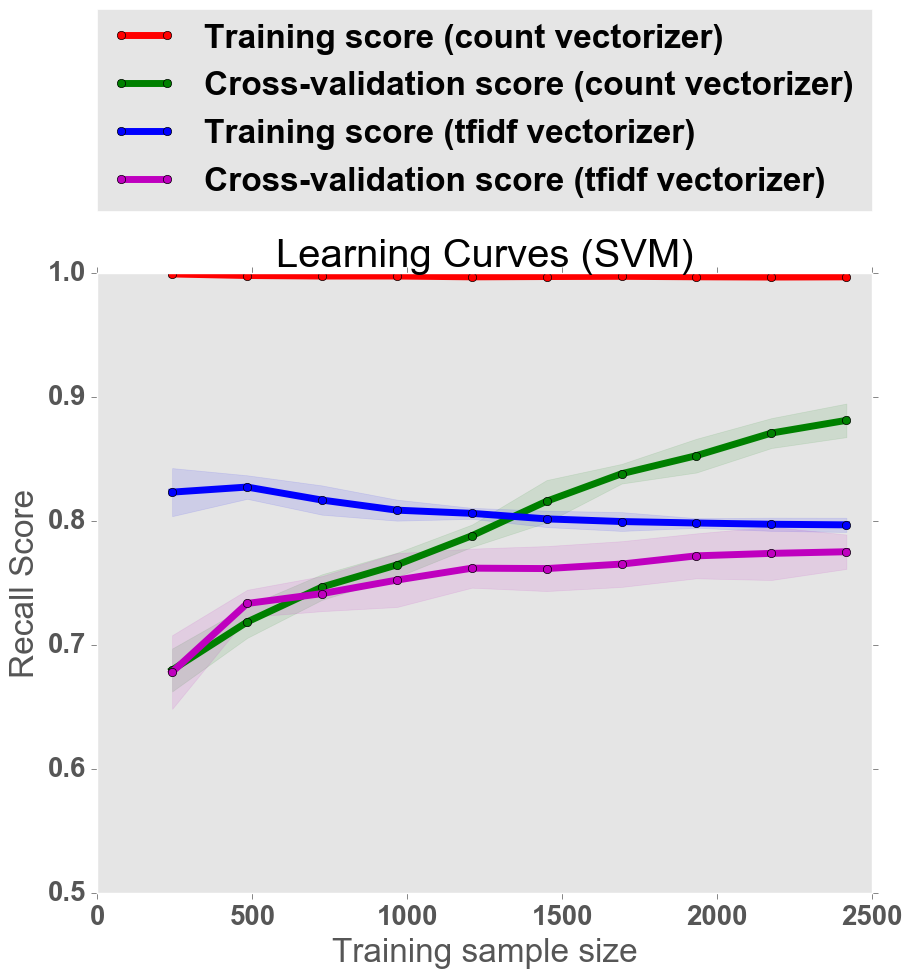

In [14]:
from sklearn.svm import LinearSVC

train_sizes_list = []
train_scores_list = []
test_scores_list = []
title = 'Learning Curves (SVM)'
# set up a SVM classifier
svc_clf_count = LinearSVC(random_state = 42)
svc_clf_tfidf = LinearSVC(random_state = 42)
# get data trained with SVM based on CountVectorizer transformation
svc_train_sizes_count, svc_train_scores_count, svc_test_scores_count = learning_curve(
                svc_clf_count, X_train_count_selected, y_train_transform, 
                cv=cv, train_sizes=train_sizes)
train_sizes_list.append(svc_train_sizes_count)
train_scores_list.append(svc_train_scores_count)
test_scores_list.append(svc_test_scores_count)

# get data trained with SVM based on TfidfVectorizer transformation
svc_train_sizes_tfidf, svc_train_scores_tfidf, svc_test_scores_tfidf = learning_curve(
                svc_clf_tfidf, X_train_tfidf_selected, y_train_transform, 
                cv = cv, train_sizes = train_sizes)
train_sizes_list.append(svc_train_sizes_tfidf)
train_scores_list.append(svc_train_scores_tfidf)
test_scores_list.append(svc_test_scores_tfidf)

# generated learning curves to measure the performance of SVM with CountVectorizer 
# or TfidfVectorizer transformated data
print plot_learning_curve(title, labels1, colors, train_sizes_list, train_scores_list, 
                          test_scores_list)

Based on the training and cross-validation curves, the performances of the SVM classifiers trained with CountVectorizer transformated data are clearly overfitted as compared with SVM classifiers trained with TfidfVectorizer.

#### 5.2 Parameter optimization for SVM

In [15]:
# set up SVM classifiers
svc_clf_count = LinearSVC(random_state = 42)
svc_clf_tfidf = LinearSVC(random_state = 42)
# set up parameters for optimization: tol - Tolerance for stopping criteria; 
# C - Penalty parameter C of the error term;
# max_iter - The maximum number of iterations to be run
# loss - Specifies the loss function. ‘hinge’ is the standard SVM loss 
# (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss. 
svc_parameters = {'tol' : np.logspace(-8, -3, 5),
                     'C' : np.logspace(-3, 3, 6),
                     'max_iter' : [50, 100, 200, 500, 1000],
                     'loss' : ['hinge', 'squared_hinge']} 
# search parameters for SVM trained with CountVectorizer transformed data
svc_best_params_count = search_best_params(X_train_count_selected, y_train_transform,svc_clf_count,
                                      svc_parameters)
# search parameters for SVM trained with TfidfVectorizer transformed data
svc_best_params_tfidf = search_best_params(X_train_tfidf_selected, y_train_transform, svc_clf_tfidf,
                                      svc_parameters)
print 'Best parameters for count vectorizer (SVM): ', svc_best_params_count
print 'Best parameters for tfidf vectorizer (SVM): ', svc_best_params_tfidf

Best parameters for count vectorizer (SVM):  {'loss': 'squared_hinge', 'C': 3.9810717055349691, 'max_iter': 100, 'tol': 1e-08}
Best parameters for tfidf vectorizer (SVM):  {'loss': 'hinge', 'C': 63.0957344480193, 'max_iter': 1000, 'tol': 1e-08}


#### 5.3 Plot learning curves for SVM with optimized parameters

<module 'matplotlib.pyplot' from '/Volumes/Work/DataScience/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>


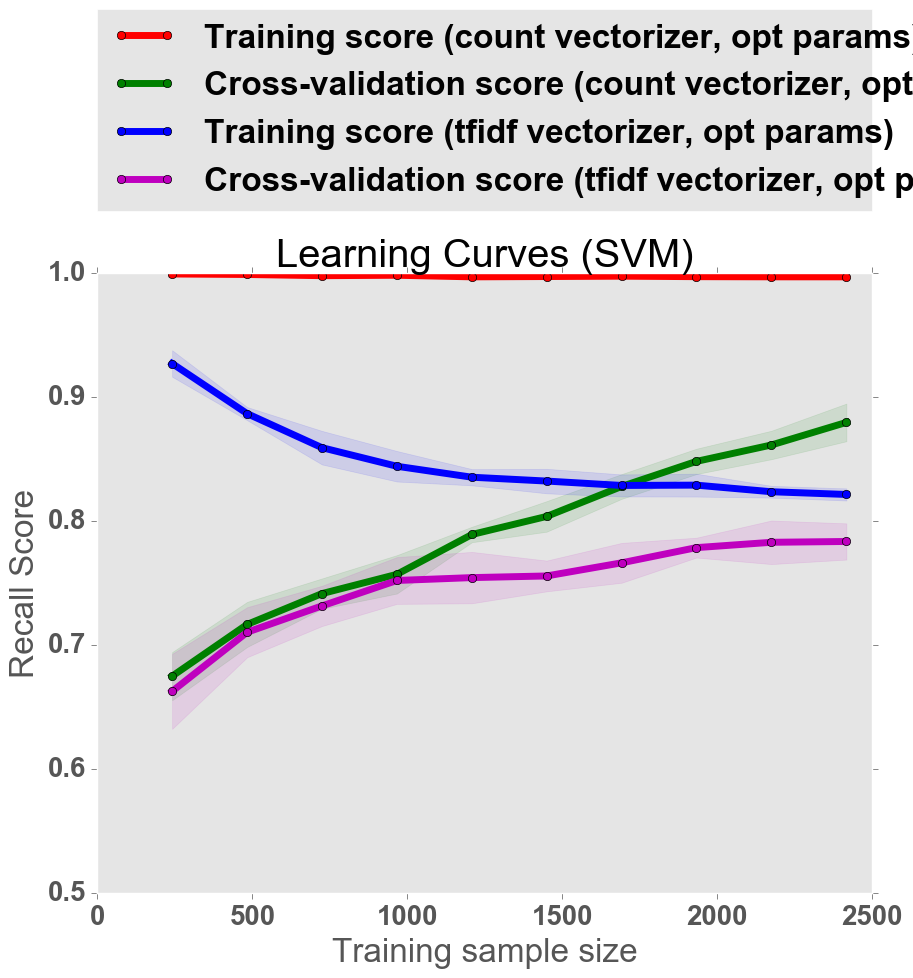

In [16]:
train_sizes_list = []
train_scores_list = []
test_scores_list = []
# define SVM with optimized parameters
svc_clf_count_best = LinearSVC(random_state = 42, **svc_best_params_count)
svc_clf_tfidf_best = LinearSVC(random_state = 42, **svc_best_params_tfidf)

# get data trained with SVM based on CountVectorizer transformation
# and optimized parameters
svc_train_sizes_count_best, svc_train_scores_count_best, svc_test_scores_count_best = learning_curve(
                svc_clf_count_best, X_train_count_selected, y_train_transform, 
                cv=cv, train_sizes=train_sizes)
train_sizes_list.append(svc_train_sizes_count_best)
train_scores_list.append(svc_train_scores_count_best)
test_scores_list.append(svc_test_scores_count_best)

# get data trained with SVM based on CountVectorizer transformation 
# and optimized parameters
svc_train_sizes_tfidf_best, svc_train_scores_tfidf_best, svc_test_scores_tfidf_best = learning_curve(
                svc_clf_tfidf_best, X_train_tfidf_selected, y_train_transform, 
                cv=cv, train_sizes=train_sizes)
train_sizes_list.append(svc_train_sizes_tfidf_best)
train_scores_list.append(svc_train_scores_tfidf_best)
test_scores_list.append(svc_test_scores_tfidf_best)

# generated learning curves to measure the performance of SVM with CountVectorizer 
# or TfidfVectorizer transformated data and optimized parameters
print plot_learning_curve(title, labels2, colors, train_sizes_list, train_scores_list, 
                          test_scores_list)

### 7. Final comparisons
Finally, the 4 models with optimized parameters are compared with test data based on their perdiction performance and running time.

                      accu_score  precision  recall_score      time
Logistic \n(default)   69.403974  69.849875     69.373491  0.005914
Logistic \n(opt)       73.642384  73.745451     73.628810  0.029928
SVM \n(default)        73.245033  73.593583     73.220401  0.007690
SVM \n(opt)            73.245033  73.411772     73.227769  0.033128


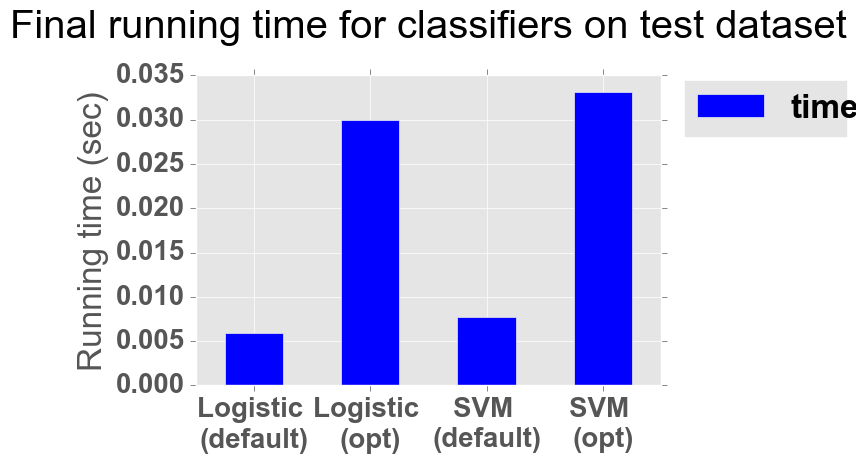

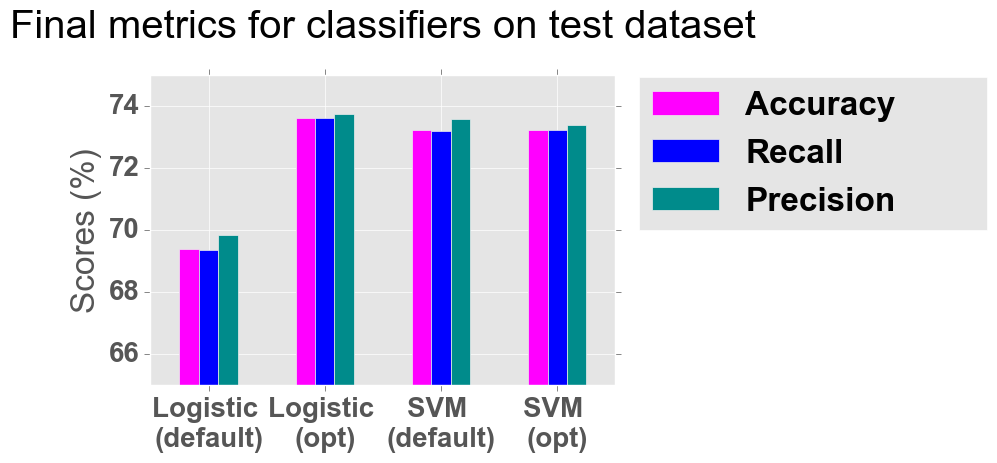

In [17]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, classification_report
import time

# transform test data
X_test_count = count_vec.transform(X_test)
X_test_tfidf = tfidf_vec.transform(X_test)
# apply feature selection model for test data
X_test_tfidf_selected = model_tfidf.transform(X_test_tfidf)
X_test_count_selected = model_count.transform(X_test_count)

# transform the labels for test data
y_test_transform = [labels_dict[y] for y in y_test]

# set up LogisticRegression classifiers
lr_clf_count = LogisticRegression(random_state=42)
lr_clf_tfidf = LogisticRegression(random_state=42)
lr_clf_count_best = LogisticRegression(random_state=42,**lr_best_params_count)
lr_clf_tfidf_best = LogisticRegression(random_state=42,**lr_best_params_tfidf)
# set up SVM classifiers
svc_clf_count = LinearSVC(random_state = 42)
svc_clf_tfidf = LinearSVC(random_state = 42)
svc_clf_count_best = LinearSVC(random_state = 42, **svc_best_params_count)
svc_clf_tfidf_best = LinearSVC(random_state = 42, **svc_best_params_tfidf)

# train LogisticRegression classifier with CountVectorizer transformated data and predict
t1 = time.time()
lr_clf_count.fit(X_train_count_selected, y_train_transform)
pred_lr_count = lr_clf_count.predict(X_test_count_selected)
t2 = time.time()
lr_clf_count_best.fit(X_train_count_selected, y_train_transform)
pred_lr_count_best = lr_clf_count_best.predict(X_test_count_selected)
t3 = time.time()

# train LogisticRegression classifier with TfidfVectorizer transformated data and predict
lr_clf_tfidf.fit(X_train_tfidf_selected,y_train_transform)
pred_lr_tfidf = lr_clf_tfidf.predict(X_test_tfidf_selected)
t4 = time.time()
lr_clf_tfidf_best.fit(X_train_tfidf_selected,y_train_transform)
pred_lr_tfidf_best = lr_clf_tfidf_best.predict(X_test_tfidf_selected)
t5 = time.time()

# train SVM classifier with CountVectorizer transformated data and predict
svc_clf_count.fit(X_train_count_selected, y_train_transform)
pred_svc_count = svc_clf_count.predict(X_test_count_selected)
t6 = time.time()
svc_clf_count_best.fit(X_train_count_selected, y_train_transform)
pred_svc_count_best = svc_clf_count_best.predict(X_test_count_selected)
t7 = time.time()

# train SVM classifier with TfidfVectorizer transformated data and predict
svc_clf_tfidf.fit(X_train_tfidf_selected, y_train_transform)
pred_svc_tfidf = svc_clf_tfidf.predict(X_test_tfidf_selected)
t8 = time.time()
svc_clf_tfidf_best.fit(X_train_tfidf_selected, y_train_transform)
pred_svc_tfidf_best = svc_clf_tfidf_best.predict(X_test_tfidf_selected)
t9 = time.time()

# print out final comparison results
clfs = ['Logistic \n(default)', 
        'Logistic \n(opt)', 
        'SVM \n(default)', 
        'SVM \n(opt)']
times = [t4 - t3, t5 - t4, t8 - t7, t9 - t8]
preds = [pred_lr_tfidf, 
        pred_lr_tfidf_best, 
        pred_svc_tfidf,
        pred_svc_tfidf_best]
accuracy_scores = [accuracy_score(y_test_transform, pred)*100 for pred in preds]
recall_scores = [recall_score(y_test_transform, pred, average = 'macro')*100 for pred in preds]
precision_scores = [precision_score(y_test_transform, pred, average = 'macro')*100 for pred in preds]
f1_scores = [f1_score(y_test_transform, pred)*100 for pred in preds]
# put data into pandas dataframe
df = pd.DataFrame({'time':times, 'accu_score': accuracy_scores, 'recall_score': recall_scores, 
                   'precision': precision_scores})
df.index = clfs
# print the data
print df
# plot the time graph
plt.Figure(figsize = (15,8))
df[['time']].plot(kind = 'bar', color = ['b'], rot = 0)
plt.legend(['time'], bbox_to_anchor=(1.05, .8, 0.35, 0),loc=3, mode="expand",
                   borderaxespad=0.)
plt.ylabel('Running time (sec)')
plt.title('Final running time for classifiers on test dataset', y = 1.1)
# plot the final metrics graph
plt.Figure(figsize = (15,8))
df_1 = df[['accu_score', 'recall_score', 'precision']]
df_1.plot(kind = 'bar', color = ['magenta', 'blue', 'darkcyan'], rot = 0)
plt.ylim([65, 75])
plt.legend(['Accuracy', 'Recall', 'Precision'], bbox_to_anchor=(1.05, 0.5, 0.75, 0),loc=3, mode="expand",
                   borderaxespad=0.)
plt.ylabel('Scores (%)')
plt.title('Final metrics for classifiers on test dataset', y = 1.1)

The LogisticRegression classifier trained with TfidfVectorizer transformated data yields best performance of prediction based on the metrics of recall.

Then, I examined the confusion matrix for LogisticRegression trained with tfidf features with optimized parameters

Confusion matrix, without normalization
[[292  87]
 [112 264]]
Normalized confusion matrix
[[ 0.78  0.23]
 [ 0.3   0.71]]


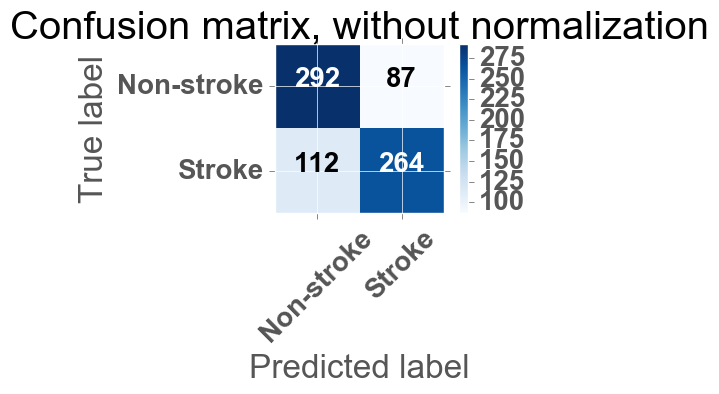

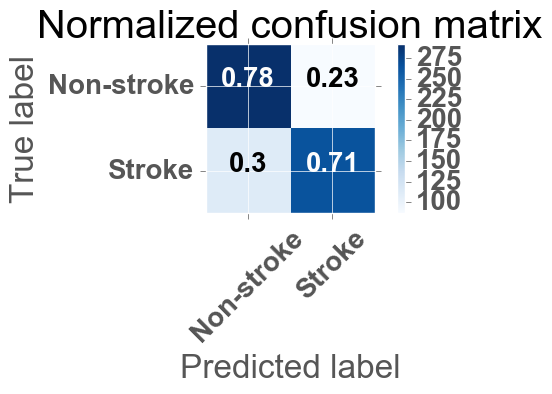

             precision    recall  f1-score   support

          0       0.72      0.77      0.75       379
          1       0.75      0.70      0.73       376

avg / total       0.74      0.74      0.74       755



In [18]:
from sklearn.metrics import confusion_matrix
import itertools
import math
from sklearn.metrics import classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        for i in range(2):
            cm[i] = [math.ceil(j*100)/100 for j in cm[i]]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_transform, pred_lr_tfidf_best)
np.set_printoptions(precision=2)
class_names = ['Non-stroke', 'Stroke']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print classification_report(y_test_transform, pred_lr_tfidf_best)

## Conclusion and Discussion

In this analysis, I analyzed the real deidentified medical records and implemented predictive models to predict the risk of stroke. I implemented two predictive models, LogisticRegression classifier and Linear support vector machine classifier, and compared their performances for prediction. To improve the performance of prediction, the following techniques are applied:  1) split the data into train data (for model selection) and test data (for model validation), 2) use natural language processing (apply stemming to text, compute occurance of words or term frequency–inverse document frequency to transform text notes, 3) perform lasso feature selection using linear support vector classifier, 4) implement and optimize two popular text classifier: the LogisticRegression and Support Vector Machine classifiers, 5) compare the performance of the optimized classifiers that are trained with occurance of words or term frequency–inverse document frequency. And their final performances are measured and compared with test dataset. Based on the final performance with test dataset, the optimized LogisticRegression trained with Tfidf transformed data showed best performance for prediction. 